# 0) : Set up

### Import librarires

In [ ]:
import os
from tqdm import tqdm_notebook as tqdm
import warnings
# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo
from torch.utils.data import Dataset, DataLoader, RandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.optim import Adam,SGD
import torchvision
import torchvision.models as models

import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils
import time

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
GPU = True
if GPU :
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/mvadlmi'

# image and mask directories
data_dir = f'{BASE_PATH}'

# Location of training labels
train_df = pd.read_csv(f'{data_dir}/train/train/train.csv')

test_df = pd.read_csv(f'{BASE_PATH}/test/test/test.csv')
test_karo = test_df[test_df['data_provider']=='karolinska']
test_radboud = test_df[test_df['data_provider']=='radboud']

In [ ]:
#remove labels that don't have a mask
taboo = ['f12da90682826a7b149fc550722e14c4','3ae66332c2dd50c6ce458937d49f8232']
train_df = train_df[~train_df['image_id'].isin(taboo)]
train_karo = train_df[train_df['data_provider']=='karolinska']
train_radboud = train_df[train_df['data_provider']=='radboud']

In [ ]:
import pickle
file = open('/content/drive/MyDrive/map_id_tiles_train_ski_image.pkl', "rb")
tiles_train = pickle.load(file)
file.close()

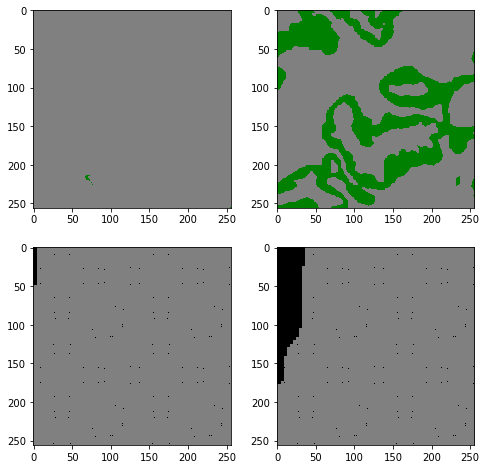

In [ ]:
images = train_df['image_id'][22:24]
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
f, axes = plt.subplots(2, 2, figsize=(8, 8))
flag = True
for i,image in enumerate(images):
    for j in range(2):
        mask = tiles_train[image][j]['mask'][:,:,0]
        axes[i,j].imshow(mask, cmap=cmap, vmin=0, vmax=6)
plt.show()

In [ ]:
def encode(mask,label):
    mask = mask.astype(np.int16)
    mask = np.rollaxis(np.eye(label, dtype=np.uint8)[mask], -1, 0)
    return mask

images_radboud = train_radboud['image_id']
images_karo = train_karo['image_id']

for i,image in enumerate(images_radboud):
    for j in range(36):
        tiles_train[image][j]['mask']=encode(tiles_train[image][j]['mask'][:,:,0],6)

for i,image in enumerate(images_karo):
    for j in range(36):
        tiles_train[image][j]['mask']=encode(tiles_train[image][j]['mask'][:,:,0],3)
        

In [ ]:
print(tiles_train[image][1]['mask'].shape)

(3, 256, 256)


# 1) : Create dataloader

### Create dataset

In [ ]:
class Segmentation_data(Dataset):
    def __init__(self, anotation , tiles, mode='train'):
        self.anotation = anotation
        self.mode = mode
        self.tiles = tiles
        
    def __len__(self):
        return len(self.anotation)
    
    def __getitem__(self, idx):
        img_id  = self.anotation.loc[idx,['image_id']].values[0]
        tiles_im = self.tiles[img_id]
        if self.mode == 'train' :
            return tiles_im, self.mode
        else :
            return tiles_im, img_id

### override collate function

In [ ]:
def default_collate_ml(batch):
    
    x_train = []
    y_train = []
    if batch[0][1] == 'train' :
        for i in range(len(batch)):
            x_train.extend([torch.FloatTensor(tile['image']).permute(2,1,0) for tile in batch[i][0]])
            y_train.extend([torch.FloatTensor(tile['mask']) for tile in batch[i][0]])

        data_x = torch.stack(x_train, dim=0)
        data_y = torch.stack(y_train, dim=0)
        return data_x, data_y



    else :  
        for i in range(len(batch)):
            x_train.extend([torch.FloatTensor(tile['image']).permute(2,1,0) for tile in batch[i][0]])
            y_train.append(batch[i][1])
        data_x = torch.stack(x_train, dim=0)
        return data_x, y_train[0]


    

In [ ]:
#@title
"""import albumentations as A
from albumentations.pytorch import ToTensorV2
SIZE = 128
transforms_train = A.Compose([
    A.RandomResizedCrop(height=SIZE, width=SIZE, p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),

    # Pixels
    A.OneOf([
        A.IAAEmboss(p=1.0),
        A.IAASharpen(p=1.0),
        A.Blur(p=1.0),
    ], p=0.5),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=1.0),
        A.IAAPiecewiseAffine(p=1.0)
    ], p=0.5),

    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])"""

### Create train loaders

In [ ]:
batch_size = 1

train, valid = train_test_split(train_karo,test_size=0.2)
train_dataset = Segmentation_data(train.reset_index(drop=False),tiles_train)
valid_dataset = Segmentation_data(train.reset_index(drop=False),tiles_train)
train_loader_k = DataLoader(dataset=train_dataset, collate_fn = default_collate_ml,batch_size=batch_size, shuffle=True)
valid_loader_k = DataLoader(dataset=valid_dataset, collate_fn = default_collate_ml,batch_size=batch_size, shuffle=False)

train, valid = train_test_split(train_radboud,test_size=0.2)
train_dataset = Segmentation_data(train.reset_index(drop=False),tiles_train)
valid_dataset = Segmentation_data(train.reset_index(drop=False),tiles_train)
train_loader_r = DataLoader(dataset=train_dataset, collate_fn = default_collate_ml,batch_size=batch_size, shuffle=True)
valid_loader_r = DataLoader(dataset=valid_dataset, collate_fn = default_collate_ml,batch_size=batch_size, shuffle=False)

# 2) Create model

In [ ]:
def get_activation(activation_type):
    activation_type = activation_type.lower()
    if hasattr(nn, activation_type):  return getattr(nn, activation_type)()
    else:  return nn.ReLU()

class ConvBatchNorm(nn.Module):
    """This block implements the sequence: (convolution => batchnorm => ReLU)"""  
    def __init__(self, in_channels, out_channels, activation='ReLU'):
        super(ConvBatchNorm, self).__init__()

        # Add 2D convolution
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=3, padding=1)
        # Add BatchNorm
        self.norm = nn.BatchNorm2d(out_channels)
        # Add Activation
        self.activation = get_activation(activation)
      
    def forward(self, x):
        out_conv = self.conv(x)
        out_norm = self.norm(out_conv)
        out_activation = self.activation(out_norm)
        return out_activation

In [ ]:
# Create instance of ConvBatchNorm
batch_conv = ConvBatchNorm(2, 64)

# Define a random input tensor of shape (batch size=1, n_channels=2, H=1024, W=1024)
x = torch.rand((1, 2, 512, 512))

# Forward throught the batch_conv
y = batch_conv(x)

# Print shape of output tensor - check that the number of channels changed
y.shape

torch.Size([1, 64, 512, 512])

In [ ]:
def _make_nConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
    layers = []
    layers.append(ConvBatchNorm(in_channels, out_channels, activation))
    for _ in range(nb_Conv-1):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))
    return nn.Sequential(*layers)

class DownBlock(nn.Module):
    """
    Encoder building block.
    Downscaling with maxpooling and convolutions: 
        (maxpooling => conv_block => conv_block) 
    """
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(DownBlock, self).__init__()

        # Create instances of layers
        self.maxpool = nn.MaxPool2d(2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x):
        # Apply layers to input x
        out = self.maxpool(x)
        out =  self.nConvs(out)  
        return out

In [ ]:
# Create instance of DownBlock
down = DownBlock(in_channels=2, out_channels=64, nb_Conv=2)

# Define a random input tensor 
x = torch.rand((1, 2, 1024, 1024))

# Forward throught the down block
y = down(x)

# Print shape of output tensor
y.shape


torch.Size([1, 64, 512, 512])

In [ ]:
class UpBlock(nn.Module):
    """
    Decoder building block.
    Upscaling then Convolutional blocks:
        (upsampling => skip connection => conv_block => conv_block)
    """
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(UpBlock, self).__init__()      

        # Create instances of upsampling layers and convolutional blocks
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x, skip_x):
        # apply upsampling
        out = self.up(x)

        # Skip connection (use torch.cat function)
        out = torch.cat([out, skip_x], dim=1) # dim 1 is the channel dimension

        # Apply convolutional blocks
        out = self.nConvs(out)
        return out

In [ ]:
""" DEBUG """

# Create instance of UpBlock
up = UpBlock(in_channels=64, out_channels=32, nb_Conv=2)

# Define a random input tensor 
x = torch.rand((1, 64, 512, 512))

# Define what would be a corresponding skipped input tensor
skip_x = torch.rand((1, 32, 1024, 1024))

# Forward through bottlenech
y = up(x, skip_x)

# Print shape of output tensor
y.shape

torch.Size([1, 32, 1024, 1024])

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=6):
        '''
        in_channels : number of channels of the input. 
                        By default 3, because we have 3 colors
        n_classes : number of channels of the ouput.
                      By default 5 (5 labels)
        '''
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes

        # Create instances of blocks and layers

        # First 2 convolutional blocks                                #input: (4 x 1024 x 1024)
        self.inconv = _make_nConv(self.in_channels, 64, nb_Conv=2)    #output (64 x 1024 x 1024)

        # Create downblocks for encoder
        self.down1 =   DownBlock(64, 128, nb_Conv=2)     # output (128 x 512 x 512)
        self.down2 =   DownBlock(128, 256, nb_Conv=2)    # output (256 x 256 x 256)
        self.down3 =   DownBlock(256, 512, nb_Conv=2)    # output (512 x 128 x 128)
        #self.down4 =   DownBlock(512, 1024, nb_Conv=2)   # output (1024 x 64 x 64)
        self.Encoder = [self.down1, self.down2, self.down3]

        # Create upblocks for decoder
        #self.up1 = UpBlock(1024, 512, nb_Conv=2)      # output (512 x 128 x 128)
        self.up2 = UpBlock(512, 256, nb_Conv=2)       # output (256 x 256 x 256)
        self.up3 = UpBlock(256, 128, nb_Conv=2)       # output (128 x 512 x 512)
        self.up4 = UpBlock(128, 64, nb_Conv=2)        # output (64 x 1024 x 1024)
        self.Decoder = [self.up2, self.up3, self.up4]

        # Final 1x1 convolution
        self.outconv = nn.Conv2d(64, self.n_classes, kernel_size=1, stride=1, padding=0)   # output (4 x 1024 x 1024)
        self.last_activation = get_activation('Softmax')

    
    def forward(self, x):
        
        # Forward 
        skip_inputs = []
        x = self.inconv(x) 
        skip_inputs += [x]   
        # print(x.shape)

        # Forward through encoder
        for i, block in enumerate(self.Encoder):
            x = block(x)
            skip_inputs += [x]    
            # print(x.shape)                  

        # Reverse skip_inputs to get Last In First Out order
        skip_inputs.reverse()

        for i, block in enumerate(self.Decoder):
            # Concat with skipconnections
            skip_x = skip_inputs[i+1]
            x = block(x, skip_x)
            # print(x.shape)
        out = self.last_activation(self.outconv(x))
        return out

unet = UNet()

# Define a random input tensor 
x = torch.rand((1, 3, 512, 512))
y = unet(x)
y.shape

model = UNet(in_channels=3, n_classes=6)
#print(model)

# Image of size 96*96 with 4 modality + batch size = 1
x = torch.rand((1, 3, 912, 512))  # Batch Size x N Modalités x H x W
y = model(x)
print(y.shape)

torch.Size([1, 6, 912, 512])


In [ ]:
def dice_loss(input, target):
    
    smooth = 1.
    target = target.float()
    input = input.float()
    input_flat = input.contiguous().view(-1)
    
    target_flat = target.contiguous().view(-1)
    
    intersection = (input_flat * target_flat).sum()
    return 1 - ((2. * intersection + smooth) /
                (input_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth))

def mean_dice_loss(input, target):  
    channels = list(range(target.shape[1]))
    loss = 0
    for channel in channels:
        dice = dice_loss(input[:, channel, ...],
                         target[:, channel, ...])
        loss += dice
    return loss / len(channels)


# Choose loss function
criterion = mean_dice_loss
# Define the start learning rate
learning_rate = 1e-3 
# Define weight decay
weight_decay = 1e-5 
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Choose learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [ ]:
def print_summary(epoch, i, nb_batch, loss, batch_time, 
                  average_loss, average_time, mode):
    '''
        mode = Train or Test
    '''
    summary = '[' + str(mode) + '] Epoch: [{0}][{1}/{2}]\t'.format(
        epoch, i, nb_batch)

    string = ''
    string += ('Dice Loss {:.4f} ').format(loss)
    string += ('(Average {:.4f}) \t').format(average_loss)
    string += ('Batch Time {:.4f} ').format(batch_time)
    string += ('(Average {:.4f}) \t').format(average_time)

    summary += string
    print(summary)

# 3) Train model functions

In [ ]:
# Train the model
def train_loop(train_loader, model, criterion, optimizer, epoch):
    
    epoch_time_sum, epoch_loss_sum = [], []
    
    for i, sample in enumerate(train_loader):
        start = time.time()
        # Take variable 
        
        (irms, masks) = sample

        # print(irms.shape) # Batch * Number of Modalities * Width * Height
        
        # Put variables to GPU
        irms = irms.float().cuda()
        masks = masks.float().cuda()
        # compute model prediction
        pred_masks = model(irms)
      
        torch.cuda.empty_cache() 
        # compute loss
        dice_loss = criterion(pred_masks, masks) 

        # If in training mode ...
        if model.training:
            # Initialize optimizer gradients to zero
            optimizer.zero_grad()
            # Perform backpropagation
            dice_loss.backward()
            # Update the model's trainable parameters using the computed gradients
            optimizer.step()

        # Compute elapsed time
        batch_time = time.time() - start

        epoch_time_sum += [batch_time]
        epoch_loss_sum += [dice_loss.item()]
        average_time = np.mean(epoch_time_sum)
        average_loss = np.mean(epoch_loss_sum)

        if i % print_frequency == 1:
            print_summary(epoch + 1, i, len(train_loader), dice_loss, batch_time,
                      average_loss, average_time, 'train')
        

    return np.mean(epoch_loss_sum)

In [ ]:
def train_model(model, train_loader, valid_loader, criterion=criterion, optimizer=optimizer):
    loss_list_train = []
    loss_list_valid = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs+1))
        # train for one epoch
        torch.cuda.empty_cache() 
        model.train()
        print('Training')
        loss_list_train.append(train_loop(train_loader, model, criterion, optimizer, epoch))
        
        torch.cuda.empty_cache() 
        # evaluate on validation set
        print('Validation')
        with torch.no_grad():   # Disable gradient computation (faster and saves memory)
            model.eval()        # Disable Dropout and BatchNormalization
            loss_list_valid.append(train_loop(valid_loader, model, criterion, optimizer, epoch))
    
    return loss_list_train, loss_list_valid

    
        

### Parameters

In [ ]:
n_classes_k = 3
n_classes_r = 6
epochs =  15
print_frequency = 100


# 4) Create test masks

### Load the test tiles

In [ ]:
import pickle
file = open('/content/drive/MyDrive/map_id_tiles_test.pkl', "rb")
tiles_test = pickle.load(file)
file.close()

### seperate radboud and karolinska providers

In [ ]:
images_radboud = test_radboud['image_id']
images_karo = test_karo['image_id']

### Create loaders

In [ ]:
batch_size = 1

test_karo_dataset = Segmentation_data(test_karo.reset_index(drop=False),tiles_test, mode = 'test')
test_karo_loader = DataLoader(dataset=test_karo_dataset, collate_fn = default_collate_ml,batch_size=batch_size)

test_radboud_dataset = Segmentation_data(test_radboud.reset_index(drop=False),tiles_test, mode = 'test')
test_radboud_loader = DataLoader(dataset=test_radboud_dataset, collate_fn = default_collate_ml,batch_size=batch_size)

### create function that predicts masks given a model and a loader

In [ ]:
def predict_masks(loader,model):
    for i, sample in enumerate(loader):
            start = time.time()
            # Take variable 
            
            (irms, name) = sample

            # print(irms.shape) # Batch * Number of Modalities * Width * Height
            
            # Put variables to GPU
            irms = irms.float().cuda()
            # compute model prediction
            pred_masks = model(irms).cpu().detach().numpy()
            for j in range(36):
                tiles_test[name][j]['mask']=pred_masks[j]
        

### train models than predict masks for the two providers seperately

In [ ]:
# Create instancte of the model
model = UNet(in_channels=3, n_classes= n_classes_k)
model.cuda()
k_train_list, k_valid_list = train_model(model, train_loader_k, valid_loader_k)
predict_masks(test_karo_loader,model)

model = UNet(in_channels = 3, n_classes = n_classes_r)
model.cuda()
r_train_list, r_valid_list = train_model(model, train_loader_r, valid_loader_r)
predict_masks(test_radboud_loader, model)


******** Epoch [1/16]  ********
Training
[train] Epoch: [1][1/155]	Dice Loss 0.8449 (Average 0.8332) 	Batch Time 1.0027 (Average 0.7578) 	
[train] Epoch: [1][101/155]	Dice Loss 0.8509 (Average 0.8442) 	Batch Time 0.4313 (Average 0.4380) 	
Validation
[train] Epoch: [1][1/155]	Dice Loss 0.8267 (Average 0.8781) 	Batch Time 0.4932 (Average 0.4965) 	
[train] Epoch: [1][101/155]	Dice Loss 0.8551 (Average 0.8377) 	Batch Time 0.4927 (Average 0.4930) 	
******** Epoch [2/16]  ********
Training
[train] Epoch: [2][1/155]	Dice Loss 0.8418 (Average 0.8460) 	Batch Time 1.0017 (Average 0.7490) 	
[train] Epoch: [2][101/155]	Dice Loss 0.8418 (Average 0.8462) 	Batch Time 0.4325 (Average 0.4384) 	
Validation
[train] Epoch: [2][1/155]	Dice Loss 0.8283 (Average 0.8782) 	Batch Time 0.4927 (Average 0.5006) 	
[train] Epoch: [2][101/155]	Dice Loss 0.8537 (Average 0.8371) 	Batch Time 0.4909 (Average 0.4932) 	
******** Epoch [3/16]  ********
Training
[train] Epoch: [3][1/155]	Dice Loss 0.8168 (Average 0.8223) 	Ba

### plot dice loss

In [ ]:
def plot_diceloss(k_train, k_valid, r_train, r_valid):
   
    epochs = len(k_train)
    x=np.arange(1,epochs+1)
    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.plot(x, k_train,label='karolinska train loss')
    ax.plot(x, k_valid,label='karolinska valid loss')
    ax.plot(x, r_train,label='radboud train loss')
    ax.plot(x, r_valid,label='radboud valid loss')
        

    ax.set(xlabel='epochs', ylabel='Average Dice loss over tiles')
    ax.grid()
    ax.legend()
    ax.set_title('Average dice loss in function of epochs')
    plt.show()  

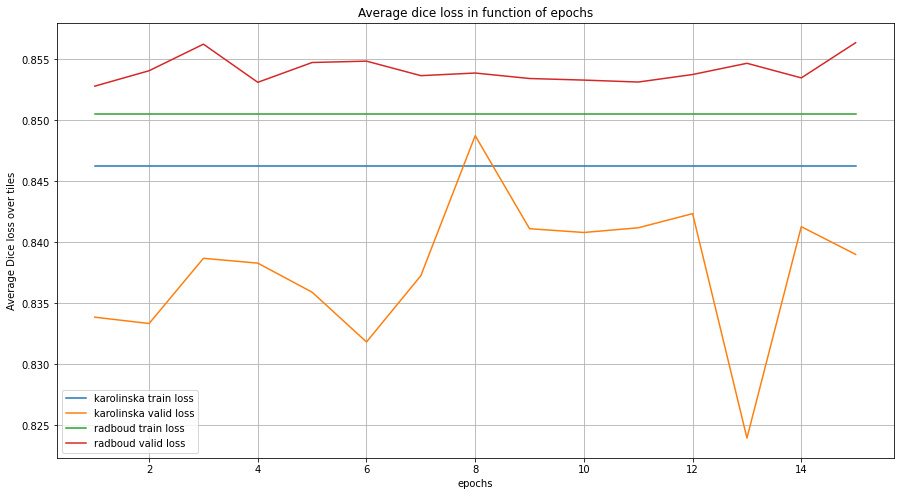

In [ ]:
plot_diceloss(k_train_list,k_valid_list,r_train_list,r_valid_list)

### decode the one hot encoding of the predictions

In [ ]:
def decode(image):
    image_d = np.zeros((image.shape[1],image.shape[2]))
    for i in range(image.shape[0]):
        image_d+=i*image[i]
    return image_d

In [ ]:
import copy
tiles_test_masks = copy.deepcopy(tiles_test)

In [ ]:
print(test_df.loc[0]['data_provider'])

radboud


In [ ]:
for i,image in enumerate(test_df['image_id']):
    for j in range(36):
        if test_df.loc[i]['data_provider']=='radboud':
            tiles_test_masks[image][j]['mask']=decode(tiles_test[image][j]['mask'])*255/5
        elif test_df.loc[i]['data_provider']=='karolinska':
            tiles_test_masks[image][j]['mask']=decode(tiles_test[image][j]['mask'])*255/5
        else :
            print('error')
            break   

### plot predicted masks

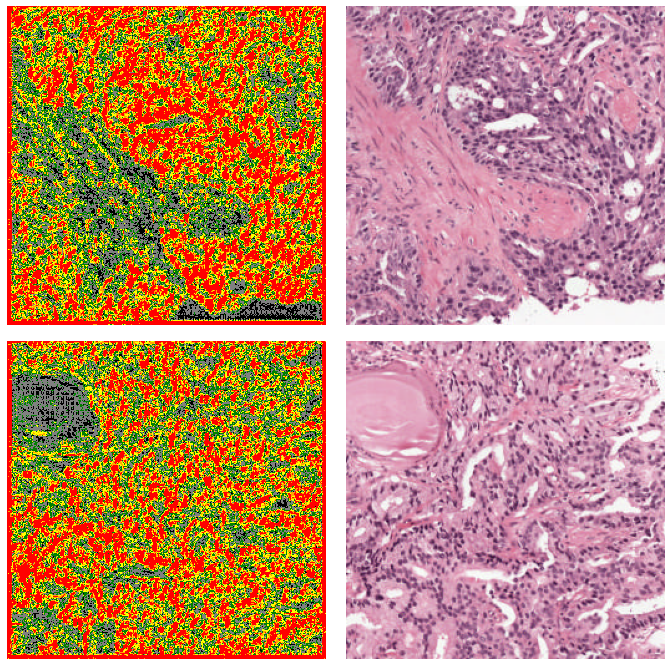

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

images = [test_radboud['image_id'][25],test_radboud['image_id'][26]]
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

plt.figure(figsize = (12,12))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

l=[]
for i,image in enumerate(images):
    mask = tiles_test_masks[image][1]['mask']
    l.append(np.transpose(mask))
    l.append(tiles_test_masks[image][1]['image'])


for i in range(4):
    ax1 = plt.subplot(gs1[i])
    if i%2==0:
        ax1.imshow(l[i], cmap=cmap, vmin=0, vmax=255)

        plt.axis('off')
    else :
        ax1.imshow(l[i])
        plt.axis('off')
plt.show()

### save in a dictionary

In [ ]:
file = open("tiles_test_withmasks", "wb")
pickle.dump(tiles_test_masks,file)
file.close()